In [112]:
import glob
import json
import joblib
import pathlib
import h5py
import numpy as np
import pandas as pd
from obspy import UTCDateTime
import matplotlib.pyplot as plt

In [113]:
# Load channels list
with open("channels_to_read_new.json", 'r') as f:
    channels_to_read_new = json.load(f)

# File Paths
data_dir = ("DAS_data/")

# Load and Sort File List
nr_files_to_load = 3
nr_files_to_process = nr_files_to_load - 2
files_list = sorted(glob.glob(data_dir + "*.hdf5"))
nr_files = len(files_list)

print(f"{nr_files} .hdf5 files are in list to be processed.")

240 .hdf5 files are in list to be processed.


In [114]:
def peak_h5_idas2_data(file):
    """
    Looks at a native silixa iDAS .h5 file and returns some fields from the
    metadata in the header
    """
    file = pathlib.Path(file)
    with h5py.File(file, "r") as f:
        dset = f['raw_das_data']
        # dtype = dset.dtype

        ddims = dset.shape
        nsamp = ddims[0]
        # nchan = ddims[1]

        metadata = dict(dset.attrs)
        starttime = UTCDateTime(str(metadata["starttime"]))

        fs = int(metadata["sampling_frequency_Hz"])
        dx = float(metadata["spatial_resolution_m"])
        d0 = float(metadata["start_distance_m"])
        endtime = starttime + ((nsamp-1)/float(fs))

        return starttime, endtime, fs, dx, d0

In [115]:
def read_idas2_h5_file(file, stream=True, channels=[0, -1], auxiliary=True):
    file = pathlib.Path(file)
    with h5py.File(file, "r") as f:
        dset = f['raw_das_data']

        ddims = dset.shape
        nsamp = ddims[0]

        metadata = dict(dset.attrs)
        starttime = UTCDateTime(str(metadata["starttime"]))

        fs = int(metadata["sampling_frequency_Hz"])
        dx = float(metadata["spatial_resolution_m"])
        d0 = float(metadata["start_distance_m"])

        if channels == [0, -1]:
            data = np.array(dset[:, :])
        elif len(channels) > 2:
            data = np.array(dset[:, channels])
        else:
            data = np.array(dset[:, channels[0]:channels[-1]])

        if stream:
            st = Stream()
            trace_l = (("sampling_rate", int(fs)),
                       ("delta", 1./int(fs)),
                       ("calib", 1.),
                       ("npts", int(nsamp)),
                       ("network", "XS"),
                       ("station", ""),
                       ("starttime", starttime))
            trace_dict = {key: value for (key, value) in trace_l}

            for i in range(data.shape[1]):
                tr = obspy.Trace(data=data[:, i], header=trace_dict)
                tr.stats.distance = d0 + (i+channels[0])*dx
                tr.stats.channel = "ESN"
                tr.stats.station = "D" + "{0:05d}".format(i+channels[0])
                st.__iadd__(tr)

            if auxiliary:
                st.metadata = metadata

            return(st)
        else:
            return(data, channels, metadata)

In [116]:
def read_idas2_h5_files(files, as_stream=False, stream=True, channels=[0, -1],
                        auxiliary=True, merge=True, sort=True):
    """Reader function for idas2 .hdf5 files. Subroutine called by das_reader,
    so for details, please look at das_reader.

    Args:
        files ([type]): [description]
        as_stream (bool, optional): [description]. Defaults to False.
        stream (bool, optional): [description]. Defaults to True.
        channels (list, optional): [description]. Defaults to [0, -1].
        auxiliary (bool, optional): [description]. Defaults to True.
        merge (bool, optional): [description]. Defaults to True.
        sort (bool, optional): [description]. Defaults to True.

    Returns:
        [type]: [description]
    """

    if not isinstance(files, list):
        files = [files]

    for i in range(len(files)-1):
        starttime0, endtime0, fs0, dx0, d00 = peak_h5_idas2_data(files[i])
        starttime1, endtime1, fs1, dx1, d01 = peak_h5_idas2_data(files[i+1])

        if (fs0 == fs1) & (dx0 == dx1) & (d00 == d01):
            pass
        else:
            print("Warning: Different acquisition parameters. Skipping file: {}".format(files[i]))
            a.write(str(files[i]));a.write(' - Warning: Different acquisition parameters');a.write('\n')
            continue

        # if starttime1 == endtime0+(1./fs1):
        #     pass
        # else:
        #     print("Warning: Misaligned data (gaps or overlap). Skipping file: {}".format(files[i]))
        #     a.write(str(files[i]));a.write(' - Warning: Misaligned data');a.write('\n')
        #     continue

    if as_stream:
        stream = True
        # WORKING WITH STREAM OBJECTS DIRECTLY (one stream per file)
        st = Stream()
        iter_ = (i for i in range(len(files)))

        for file in files:
            i = next(iter_)
            st_tmp = read_idas2_h5_file(
                file, stream=stream, channels=channels, auxiliary=auxiliary)
            st += st_tmp
            if i == 0:
                st.metadata = st_tmp.metadata

        if merge:
            if not st.get_gaps():
                st.merge(method=1).sort()
            else:
                warnings.warn("Gaps or overlap in the data. Returned stream"
                              + "object is not merged!", UserWarning)
                if True:
                    st.print_gaps()
        if sort:
            st.sort()
        return st

    else:
        iter_ = (i for i in range(len(files)))
        for file in files:
            i = next(iter_)
            if i == 0:
                data, channels, metadata = read_idas2_h5_file(
                    file, stream=False, channels=channels, auxiliary=auxiliary)

            else:
                data_tmp, _, _ = read_idas2_h5_file(
                    file, stream=False, channels=channels, auxiliary=auxiliary)
                data = np.vstack([data, data_tmp])

        if stream:
            if not merge:
                warnings.warn(
                    "merge=True was set because of working with the numpy"
                    + "arrays", UserWarning)

            starttime = UTCDateTime(str(metadata["starttime"]))
            fs = int(metadata["sampling_frequency_Hz"])
            dx = float(metadata["spatial_resolution_m"])
            d0 = float(metadata["start_distance_m"])
            # endtime = starttime + ((nsamp-1)/float(fs))

            st = Stream()
            trace_l = (("sampling_rate", int(fs)),
                       ("delta", 1./int(fs)),
                       ("calib", 1.),
                       ("npts", int(data.shape[0])),
                       ("network", "XS"),
                       ("station", ""),
                       ("starttime", starttime))
            trace_dict = {key: value for (key, value) in trace_l}


            # Added for correct channel numbers when using fancy indexing
            for i in range(data.shape[1]):
                tr = obspy.Trace(data=data[:, i], header=trace_dict)
                if len(channels) == 2:
                    tr.stats.distance = d0 + (i+channels[0])*dx
                    tr.stats.channel = "ESN"
                    tr.stats.station = "D" + "{0:05d}".format(i+channels[0])
                elif len(channels) > 2:
                    tr.stats.distance = d0 + (channels[i])*dx
                    tr.stats.station = "D" + "{0:05d}".format(channels[i])
                st.__iadd__(tr)
                

            # for i in range(data.shape[1]):
            #     tr = obspy.Trace(data=data[:, i], header=trace_dict)
            #     tr.stats.distance = d0 + (i+channels[0])*dx
            #     tr.stats.channel = "ESN"
            #     tr.stats.station = "D" + "{0:05d}".format(i+channels[0])
            #     st.__iadd__(tr)

            if auxiliary:
                st.metadata = metadata
                

            if sort:
                st.sort()
            return(st)

        else:
            return(data, channels, metadata)

In [117]:
def das_reader(files, auxiliary=True, sort=True, merge=True,
               stream=True, as_stream=False,
               channels=[0, -1], h5type='native', debug=False):
    """
    Reader function to read in iDAS data into either a numpy array or an
    obspy stream object. Default values should be: auxiliary=True,
    as_stream=False, and stream=True.
    :type files: list
    :param files: List of files to read
    :type auxiliary: bool
    :param auxiliary: If metadata (header) should be read in and saved to
    st.metadata
    :type sort: bool
    :param sort: If stream should be sorted by station
    :type merge: bool
    :param merge: If the stream object should be merged or not before returning
    :type strean: bool
    :param stream: If True, the function will return an obspy Stream object.
    If False, will return data, channels, metadata, where data is the read in
    data as 2d numpy array
    :type as_stream: bool
    :param as_stream: Decide how to read in and handle the data inside the
    reader. default to False, but if h5type is asdf, this will automatically
    be set to True. Same if there are gaps in the data, it will fall back to
    as_stream=True, because the matrix/numpy version can not handle gaps due to
    lacking of timestamping in numpy arrays
    :type channels: list of 2 values
    :param channels: Slice of channels to be read in. If default [0,-1], the
    entire data will be read in. Otherwise arbitrary slicing would be possible
    (eg. [20,50]). No interval slicing implemented yet (like [20:50:10] ).
    This is on the ToDo.
    :type h5type: str
    :param h5type: The type of the data. Either native silixa h5 as from the
    iDAS (h5type='native') or converted asdf data (h5type='asdf'). Now also
    works for idas2 .hdf5 files: (h5type='ida2')
    :type debug: bool
    :param debug: optional print outputs
    """
    if not isinstance(files, list):
        files = [files]

    if h5type not in ['asdf', 'native', 'idas2']:
        sys.exit('Invalid h5type specified')
    if debug:
        print('\U0001F50D Reading in: \n', files)
    if h5type == 'native':
        if stream:
            st = read_h5_native_files(files, auxiliary=auxiliary, sort=sort,
                                      merge=merge, stream=stream,
                                      as_stream=as_stream, channels=channels)
            if debug:
                print("\U00002714 success")
            return st
        else:
            data, channels, metadata = read_h5_native_files(
                files, auxiliary=auxiliary, sort=sort, merge=merge,
                stream=stream, as_stream=as_stream, channels=channels
                )
            if debug:
                print("\U00002714 success")
            return (data, channels, metadata)

    if h5type == 'idas2':
        if stream:
            st = read_idas2_h5_files(files, auxiliary=auxiliary, sort=sort,
                                     merge=merge, stream=stream,
                                     as_stream=as_stream, channels=channels)
            if debug:
                print("\U00002714 success")
            return st
        else:
            data, channels, metadata = read_idas2_h5_files(
                files, auxiliary=auxiliary, sort=sort, merge=merge,
                stream=stream, as_stream=as_stream, channels=channels
                )
            if debug:
                print("\U00002714 success")
            return (data, channels, metadata)

    if h5type == 'asdf':
        st = read_h5_asdf_files(files, stream=stream, channels=channels,
                                auxiliary=auxiliary, merge=merge, sort=sort)
        if debug:
            print("\U00002714 success")
        return st

In [118]:
def plotChRange(data, fs=1000, clipPerc=None, time_axis='vertical', cmap='seismic', dpi=200, 
                title=None, outfile=None):
    """
    Plot DAS profile for given channel range

    Parameters
    ----------
    data : numpy.ndarray
        Input data in the t-x domain
    fs : int
        Sampling frequency in Hz

    Returns
    -------
    Strain rate plot of DAS data.
    
    """
    if time_axis != 'vertical':
        data = data.T

    if clipPerc:
        clip = np.percentile(np.absolute(data), clipPerc)
        plt.figure(dpi=dpi)
        plt.imshow(data, aspect='auto', interpolation='none',
                   vmin=-clip, vmax=clip, cmap=cmap)
    else:
        plt.figure(dpi=dpi)
        plt.imshow(data, aspect='auto', interpolation='none',
                   vmin=-abs(data).max(), vmax=abs(data).max(),
                   cmap=cmap)
    plt.xlabel('Channel number')
    plt.xticks(np.linspace(0, data.shape[1], 4), [int(val) for val in np.linspace(0, data.shape[1], 4)])
    plt.ylabel('Time (s)')
    plt.yticks(np.linspace(0, data.shape[0], 4), [int(val) for val in np.linspace(0, data.shape[0]/3000, 4)])

    plt.colorbar(label='Strain rate (10$^{-9}$ s$^{-1}$)')
    plt.tight_layout()
    if title:
        plt.title(title, fontsize=16)
    if outfile:
        plt.savefig(outfile, format='png')
        plt.close('all')
        
    return

Processing File ID: 0
🔍 Reading in: 
 ['/Users/rachelwillis/myDocuments/CSMresearch/Rhone_Glacier/Rhone_Glacier_AWS_Final/20200715_070000.000-20200715_090000.000/codes/input/DAS_data/idas2_UTC_20200715_070020.719_rhone1khz.hdf5', '/Users/rachelwillis/myDocuments/CSMresearch/Rhone_Glacier/Rhone_Glacier_AWS_Final/20200715_070000.000-20200715_090000.000/codes/input/DAS_data/idas2_UTC_20200715_070050.719_rhone1khz.hdf5', '/Users/rachelwillis/myDocuments/CSMresearch/Rhone_Glacier/Rhone_Glacier_AWS_Final/20200715_070000.000-20200715_090000.000/codes/input/DAS_data/idas2_UTC_20200715_070120.719_rhone1khz.hdf5']
✔ success
Processing File ID: 1
🔍 Reading in: 
 ['/Users/rachelwillis/myDocuments/CSMresearch/Rhone_Glacier/Rhone_Glacier_AWS_Final/20200715_070000.000-20200715_090000.000/codes/input/DAS_data/idas2_UTC_20200715_070050.719_rhone1khz.hdf5', '/Users/rachelwillis/myDocuments/CSMresearch/Rhone_Glacier/Rhone_Glacier_AWS_Final/20200715_070000.000-20200715_090000.000/codes/input/DAS_data/idas

KeyboardInterrupt: 

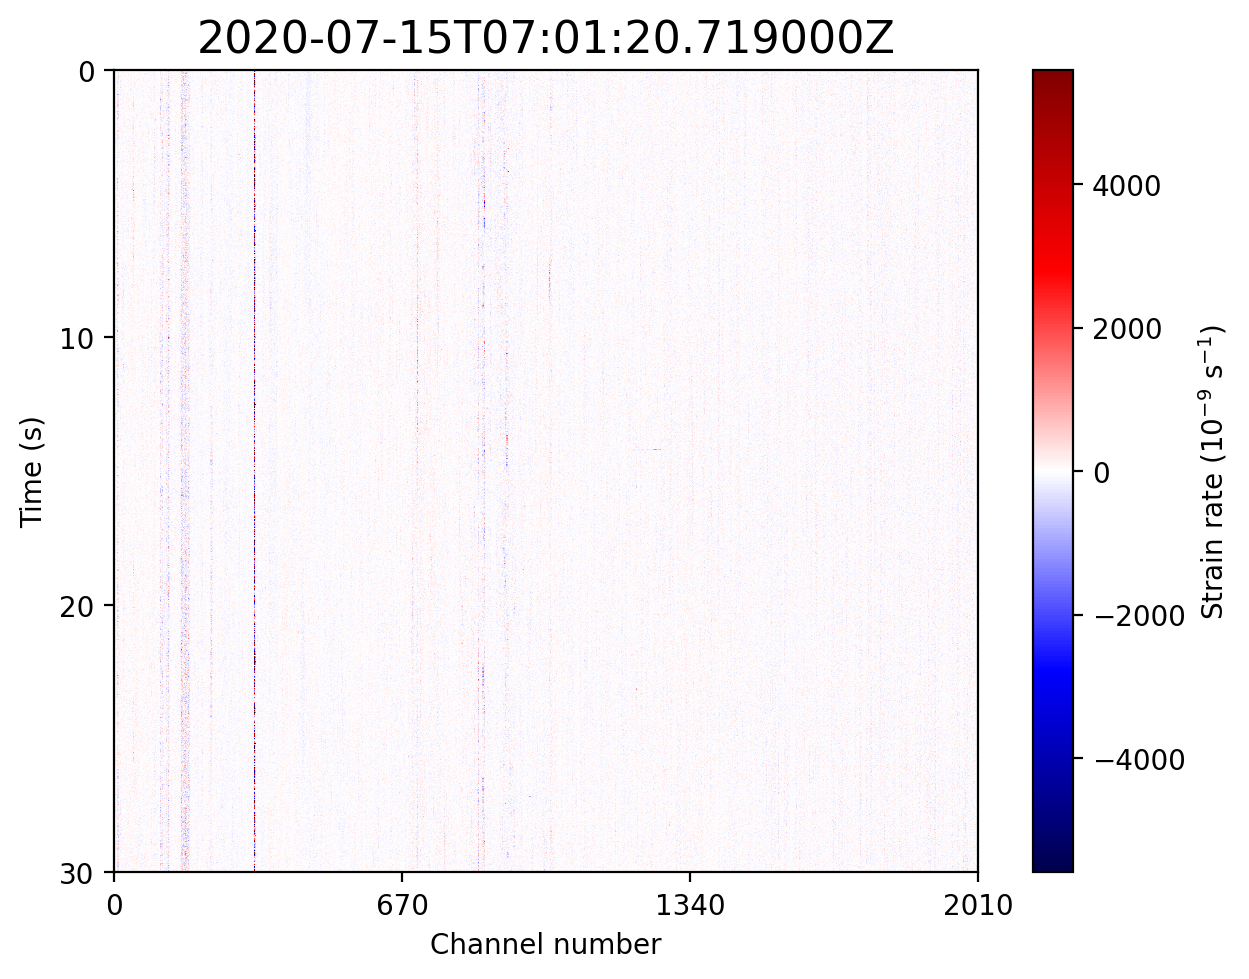

In [119]:
if __name__ == '__main__':

    for file_id in range(0, nr_files - nr_files_to_load, nr_files_to_process):
        print(f'Processing File ID: {file_id}')

        # Load Data
        st = das_reader(files_list[file_id:file_id + nr_files_to_load], stream=False,
                    channels=channels_to_read_new, h5type='idas2', debug=True)

        if st[0].shape[0] != 90000:
            continue

        sampling_rate = int(st[2]['sampling_frequency_Hz'])
        starttime = UTCDateTime(st[2]['starttime'])
                    
        plotChRange(st[0], fs=250, clipPerc=99.97, title = f'{starttime}', outfile=f'{starttime}.png')